## <font size=6> Title about atmospheric rivers and pollution</font>
<br><br>
<font size=4>
**Julia Asplund** (julia.asplund@aces.su.se), in collaboration with Lea Haberstock <p>
Date, 2022<p>
eScience Tools in Climate Science: Linking Observations with Modelling <p>
Group assistant, fearless leader, person we would not have managed without: Remy Lapere 
</font>

## Abstract

## Introduction

-Mention differences between arctic and antarctic in terms of pollution

## Methods

### Data description and preprocessing

There is one key preprocessing step of this analysis, which is the AR detection. The detection script is written by Remy Lapere, following the AR definition and detection principle developed by Wille et al (2022). This principle is to detect AR by identifying regions of adjacent gridboxes that have high poleward integrated vapour transport (IVT) between certain pressure levels. IVT is given by 

IVT $=-\frac{1}{g}  \int_{900 \textrm{ hPa} }^{300 \textrm{ hPa}} q \textbf{V} \mathit{dp} $

where g is the standard gravity, q is the specific humidity and $\textbf{V}$ is the meridional wind component. Only the positive (poleward) wind is considered. In the original algorithm by Wille et al (2022), the IVT is calculated in each gridbox for a reference period, and the threshold for "high" IVT is set to the 98th percentile in each gridbox. The for the detection, clusters of gridboxes with an IVT above the threshold and that reach at least 20$^{\cdot}$ latitude in size are considered to be AR, at each timestamp. Important to note is that this algorithm was developed for reanalysis data with 3 hourly output. In the this project we wanted to be able to look at projections of future trends in AR (see Lea's report), and therefore we use model data, more specifically the NorESM2-LM output for the historical CMIP6 experiment (Lea also uses scenarioMIP for future trends). The highest temporal resolution avalaible is daily average output. So, the fluctuations in IVT in our data are dampened compared to what was used by Wille et al (2022), and what we can detect is only the daily averaged AR. Therefore, in the detection script used for this report the IVT threshold was set to the 94th percentile of each gridbox. This threshold was chosen by tuning the detection based on a comparison with a one-year AR detection product from Jonathan Wille, see the [Supplementary material](#Supplementary-material) for details. Nevertheless, I want to emphasize that the AR detection used for this report is in many ways far from perfect, partly because of the low temporal and spatial resolution of the data but also because there simply is no objective definition of AR, and results should be interpreted with this in mind.

In this report the period 2000-2015 is selected from the historical CMIP6 run. The AR detection script must be run locally, and therefore the pre-processed file [combined_hist_q94.nc](combined_hist_q94.nc) is provided. This file is an AR mask, where the parameter `ivt` is 1 for every gridbox part of an atmospheric river at a given timestamp, and 0 otherwise. It was obtained with the script [opencv_detection_OK.py](opencv_detection_OK.py) (by Remy Lapere), also provided. 

Describe preprocessing and AR mask. Link to file. 

### Load data 

In [125]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import s3fs
import intake
import functions_JA as fun
#import os
import warnings
#from matplotlib import rc,animation
#from matplotlib.animation import FuncAnimation
#from IPython import display
#import cartopy as cy
import cartopy.crs as ccrs

In [128]:
from importlib import reload
reload(fun)

<module 'functions_JA' from '/home/jovyan/Tjaernoe2022-group5/notebooks/Julia/functions_JA.py'>

Loading AR mask, pre calculated as described:

In [8]:
ar_mask = xr.open_dataset('combined_hist_q94.nc')

Fetching AOD data from met.no:

In [9]:
#Define connection to met.no bucket
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

#path to aod data file, in Ada's folder
s3path_aod = 's3://escience2022/Ada/monthly/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_2000101-20141231.nc'

#Importing file and dropping unused parameters
aod_ds = xr.open_dataset(s3.open(s3path_aod), drop_variables =['time_bnds','lat_bnds','lon_bnds'])

In this AOD file, the timestamp is at midnight every day while the AR mask has timestamps at noon, even though it is the same model run with daily average output. Therefore I replace the AOD time with the time-array from the AR mask:

In [10]:
aod_ds['time'] = ar_mask.time

Loading variables to be considered, from pangeo:

In [11]:
#Years considered, corresponding to AR mask
start_year='2000'
end_year='2015'

#Define url and connection
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

#Search database for the right model, experiment and variables. Save catalog as dictionary, and finally as xarray dataset
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['clt','pr','tas','hus'], member_id=['r1i1p1f1'])
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dataset_list = list(dset_dict.keys())
dset = dset_dict[dataset_list[0]]
vars_ds = dset.sel(member_id='r1i1p1f1',time=slice(str(start_year)+"-01-01", str(end_year)+"-01-01"))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


### AR masking and pollution threshold

Since I want to investigate the properties of clean versus polluted AR, I need to sort the detected AR depending pollution level. The only relevant aerosol particle parameter with daily output for this CMIP experiment is AOD, and therefore it will be used to sort the AR. Aerosol particle concentrations at the poles generally very low, so low that air transported from mid latitudes will almost always be polluted in comparison. Therefore, I define the thresholds for clean and polluted AR based the AOD at mid latitudes. AR that reach the Arctic (above 60$^{\cdot}$ North) are considered polluted if the average AOD in the river is within the upper 25th percentile of AOD for the whole time period at latitudes between 30$^{\cdot}$ and 60$^{\cdot}$ North. Arctic AR with an average AOD in the lower 25th percentile are considered clean. Antarctic AR are sorted in the same way, but depending on the AOD between 30$^{\cdot}$ and 60$^{\cdot}$ South. 

In [12]:
#Creating a dictionary to store the pollution limits for the sorting of ARs 
aod_lim= {}
aod_lim['midlat_75th'] = aod_ds.sel(lat = slice(30,60)).od550aer.quantile(0.75,skipna=True)
aod_lim['midlat_25th'] = aod_ds.sel(lat = slice(30,60)).od550aer.quantile(0.25,skipna=True)
aod_lim['midlowlat_75th'] = aod_ds.sel(lat = slice(-60,-30)).od550aer.quantile(0.75,skipna=True)
aod_lim['midlowlat_25th'] = aod_ds.sel(lat = slice(-60,-30)).od550aer.quantile(0.25,skipna=True)

Now I can apply the AR mask to the AOD data and sort the rivers. The function `sort_ar_by_aod` takes the AOD dataset, the AR mask and the pollution limits, loops over every timestep, applies the mask and then checks the average AOD of every river to sort it. Returned is an AOD dataset with all gridboxes outside the rivers masked out, separated into polluted, clean, and intermediate pollution levels. These parameters can be used as an AR mask for each pollution category separately. There is also a count of the number of rivers in each category for every timestep.

In [13]:
arc_aod_ar = fun.sort_ar_by_aod(aod_ds.sel(lat=slice(60,90)), ar_mask.sel(lat=slice(60,90)), aod_lim['midlat_75th'], aod_lim['midlat_25th'])
ant_aod_ar = fun.sort_ar_by_aod(aod_ds.sel(lat=slice(-90,-60)), ar_mask.sel(lat=slice(-90,-60)), aod_lim['midlowlat_75th'], aod_lim['midlowlat_25th'])

Next I have to apply the AR masks to the dataset containing the variables of interest. The masked datasets are stored in two different dictionaries, one for each pole. In order to plot histograms of the variables they need to be in 1-dimensional arrays, with all NAN-values (from the masked out data) removed. These are also stored in the dictionaries, to simplify plotting.

In [16]:
#Create empty dictionaries to fill with variables and define variables and pollution levels considered:
arc_plotting_vars = {}
ant_plotting_vars = {}
flat_vars = ['clt','pr','tas','hus']
levs = ['clean','mid','poll']


for lev in levs:
    #Create a dictionary in each pollution level
    arc_lev_dict = {}
    ant_lev_dict = {}
    
    #Mask the dataset with the AR mask for current pollution level, separate for both ploes and store in dictionary created above.
    arc_lev_dict['ar_masked'] = vars_ds.sel(lat=slice(60,90)).where(arc_aod_ar[f'{lev}_ar_aod'].notnull() )
    ant_lev_dict['ar_masked'] = vars_ds.sel(lat=slice(-90,-60)).where(ant_aod_ar[f'{lev}_ar_aod'].notnull() )
    
    for var in flat_vars:    
        #For current variable, flatten the masked array and remove NaN values
        arc_lev_dict[f'{var}_flat']= arc_lev_dict['ar_masked'][var].values.flatten()[~np.isnan(arc_lev_dict['ar_masked'][var].values.flatten())]
        ant_lev_dict[f'{var}_flat']= ant_lev_dict['ar_masked'][var].values.flatten()[~np.isnan(ant_lev_dict['ar_masked'][var].values.flatten())]
        
        if var == 'pr':
            #Convert precipiation from kg/m^2/s to mm/day
            arc_lev_dict[f'{var}_flat']= arc_lev_dict[f'{var}_flat']*86400
            ant_lev_dict[f'{var}_flat']= ant_lev_dict[f'{var}_flat']*86400
    
    #save dictionary of data in current pollution level
    arc_plotting_vars[lev]=arc_lev_dict
    ant_plotting_vars[lev]=ant_lev_dict
    

## Results and discussion

To visually demonstrate the AR detection, below the AR mask is plotted for one timestamp for each pole featuring a detected AR in blue. 

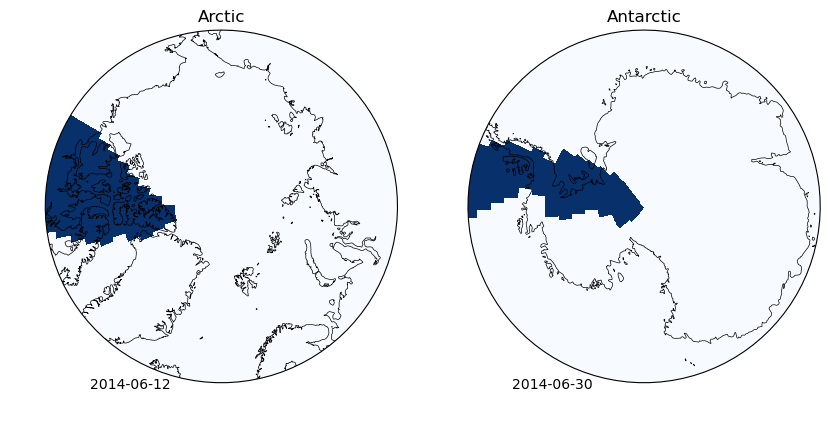

In [129]:
arc_ex_ar = ar_mask.sel(time = '2014-06-12', lat =slice(65,90))
ant_ex_ar = ar_mask.sel(time = '2014-06-30', lat =slice(-90,-65))

plot_ex_ar= {'Arctic' :arc_ex_ar, 'Antarctic' : ant_ex_ar}

fig = plt.figure(figsize = (10,5), dpi=100)

arc_ax = fig.add_subplot(121, projection=ccrs.NorthPolarStereo())
ant_ax = fig.add_subplot(122, projection=ccrs.SouthPolarStereo())

arc_ax.set_extent([0, 360, 65, 90], ccrs.PlateCarree())
ant_ax.set_extent([0, 360, -65, -90], ccrs.PlateCarree() )             

axs=[arc_ax,ant_ax]
for i, pole in enumerate(plot_ex_ar.keys()):
    axs[i].coastlines(linewidth=0.5)
    fun.circle_for_polar_map(axs[i])
    axs[i].set_title(pole)
    axs[i].pcolormesh(plot_ex_ar[pole].lon, plot_ex_ar[pole].lat, plot_ex_ar[pole].ivt.squeeze(), cmap='Blues', vmin=0,vmax=1,
                      transform=ccrs.PlateCarree() )
    fig.text(-1.3+i*1.2,-0.1,plot_ex_ar[pole].time.values.astype('datetime64[D]')[0],horizontalalignment='left',
     verticalalignment='bottom', transform=ax.transAxes)

plt.show()

This figure demonstrates the two main issues with the current detection scheme, that some rivers are too wide (left), and then many reach the center of the pole (right). ELaborate!

Number of AR by month, stacked histogram with groupby:

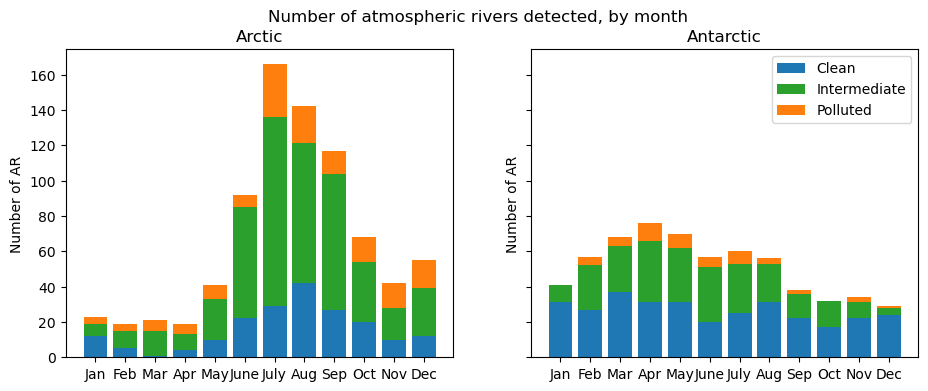

In [192]:
labels=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
arc_monthly_count = arc_aod_ar.groupby('time.month').sum(dim='time')
ant_monthly_count = ant_aod_ar.groupby('time.month').sum(dim='time')

def plot_count_bar(ax ,labels, grouped_ds, title=''):
    ax.bar(labels, grouped_ds.clean_ar_counts.values, label='Clean')
    ax.bar(labels, grouped_ds.mid_ar_counts.values, bottom = grouped_ds.clean_ar_counts.values, color='tab:green', label='Intermediate')
    ax.bar(labels, grouped_ds.poll_ar_counts.values, bottom = grouped_ds.clean_ar_counts.values+grouped_ds.mid_ar_counts.values,
        color='tab:orange', label='Polluted')
    ax.set_title(title)
    ax.set_ylabel('Number of AR')

fig, axs = plt.subplots(1,2, figsize=(11,4),dpi=100, sharey=True)
plot_count_bar(axs[0], labels, arc_monthly_count, 'Arctic')
plot_count_bar(axs[1], labels, ant_monthly_count, 'Antarctic')
fig.suptitle('Number of atmospheric rivers detected, by month')
plt.legend()
plt.show()

Discuss numbers:
Difference between poles due to differences in the stability of jetstreams, or amoc etc?

Plot seasonal Arctic:

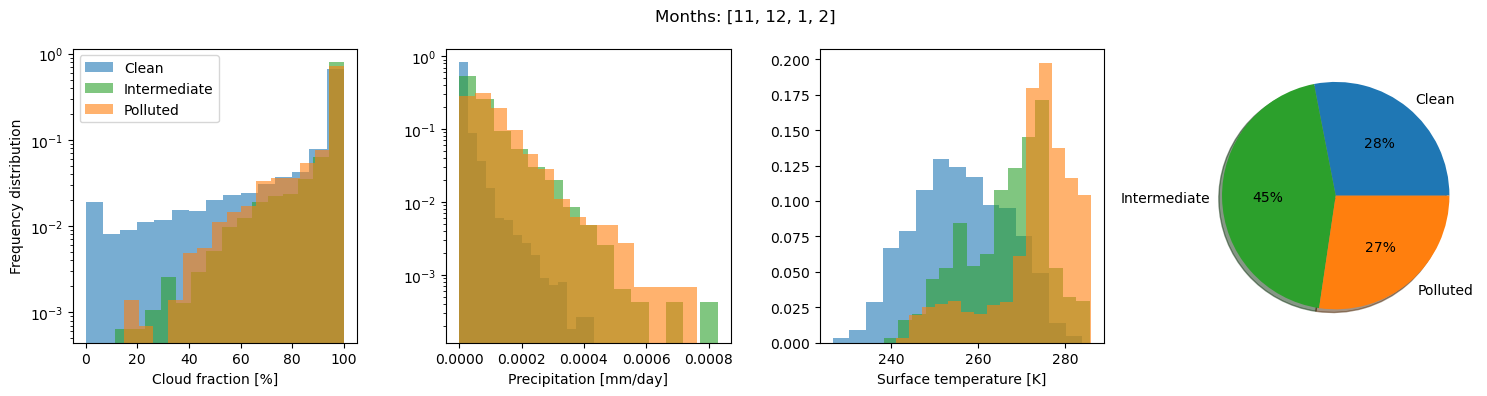

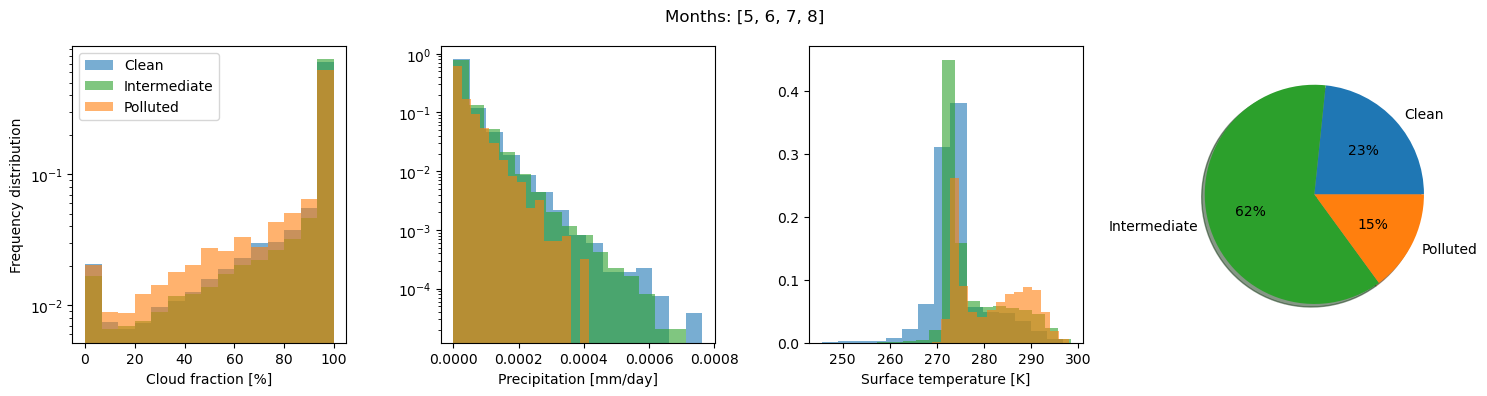

In [131]:
flat_vars = ['clt','pr','tas']
seasons = [[11,12,1,2],[5,6,7,8]]
fun.plot_hist(flat_vars,seasons, arc_plotting_vars, arc_aod_ar)

Discuss arctic

Plot seasonal Antarctic

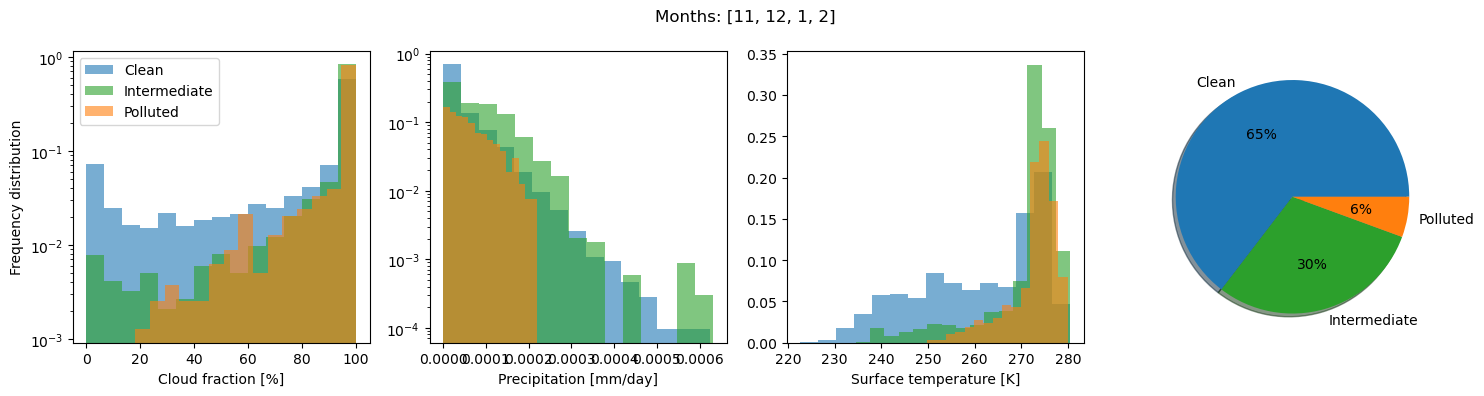

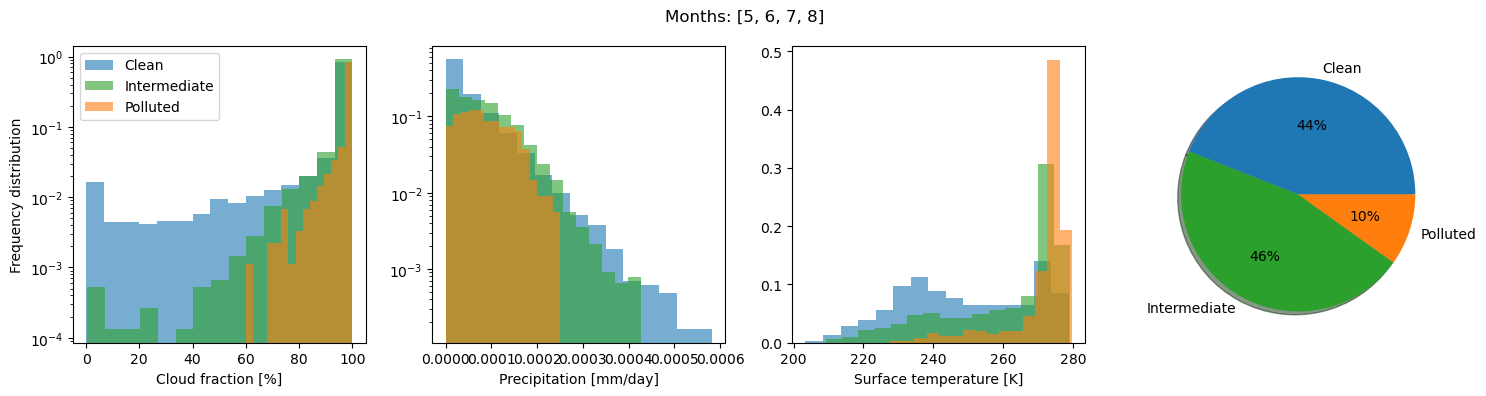

In [133]:
fun.plot_hist(flat_vars,seasons, ant_plotting_vars, ant_aod_ar)

Discuss Antarctic

Discuss
-AR detection (supplements)
-AOD vs vertically resolved aerosol parameter (Where is pollution picked up, does aod really reflect what is carried with the AR, etc)

## Summary and conclusions

## Supplementary material

Comparicon to Jonathans product, discussion and q threshold, maps for comparison